# This dataset is focus on hyperparameter tuning and at the end there is an example with multivariate forecasting
- In fuzzy time series, what are the different parameter that we can tune? 
- How to assess the performance per combination of parameter? 
- What is the effect of the number of partition on the performance of the model? 
- At what point are we overfitting by increasing the # of partitions? 
- What is the effect of order on the performance and complexity of the model? 
- How can we deal with the effect of 0 in the series.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("/Users/philippebeliveau/Desktop/Bureau/Notebook_Jupyter_R/datah-m1-challange/sales.csv")

In [6]:
df.head()

,DATE,S100,I100,C100,C101,QTT
0,2017-01-08,0,0,12,76,2
1,2017-01-08,0,0,12,149,3
2,2017-01-08,0,0,12,256,3
3,2017-01-08,0,0,12,354,3
4,2017-01-08,0,0,13,149,2


In [7]:
df.shape[0]

2749369

Starts in 2017 and end in 2021

<function matplotlib.pyplot.show(close=None, block=None)>

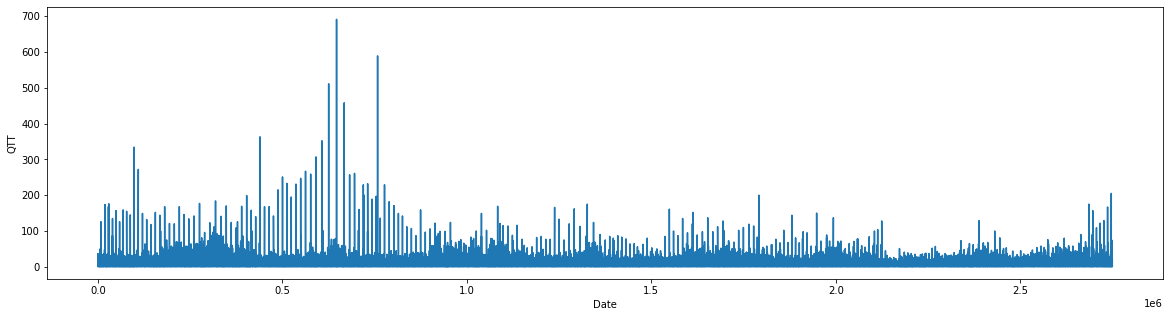

In [8]:
plt.figure(figsize=(20,5))
plt.plot(df["QTT"])

plt.xlabel("Date")
plt.ylabel("QTT")
plt.show

## Number of zeros

In [9]:
df.eq(0).sum()

DATE        0
S100    99850
I100     8841
C100     6601
C101       89
QTT         0
dtype: int64

## Transformation
We can use pyFTS own transformations tool. Although, I am not sure how are we going to integrate our own transformation in the partionning function.

In [ ]:
from pyFTS.common import Transformations

diff = Transformations.Differential(1)
fig = plt.subplots(figsize=(20,5))
plt.plot(diff.apply(df["QTT"].values), label="QTT")
pass

# Train test split
Only the training data seems to be partionned. 

### Smaller set

In [73]:
df['DATE'] = pd.to_datetime(df["DATE"], format='%Y-%m-%d')
train = df.iloc[:300000]
test = df.iloc[300001:400000]

uni_train = train["QTT"].values
multi_train = train

uni_test = test['QTT'].values
multi_test = test

In [74]:
multi_train.head()

,DATE,S100,I100,C100,C101,QTT
0,2017-01-08,0,0,12,76,2
1,2017-01-08,0,0,12,149,3
2,2017-01-08,0,0,12,256,3
3,2017-01-08,0,0,12,354,3
4,2017-01-08,0,0,13,149,2


### Bigger set

In [26]:
train = df.iloc[:2000000]
test = df.iloc[2000001:2749369]

uni_train = train["QTT"].values
multi_train = train

uni_test = test['QTT'].values
multi_test = test

# EDA
## Stationnarity test

In [2]:
from statsmodels.tsa.stattools import adfuller
rows = []
result = adfuller(uni_train)
rows.append([result[0], result[1], result[2], result[3], result[4]])
pd.DataFrame(rows,columns=['ADF Statistic','p-value','Cr. Val. 1%','Cr. Val. 5%','Cr. Val. 10%'])

NameError: name 'uni_train' is not defined

## ACF

In [ ]:
from statsmodels.tsa.stattools import acf

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(acf(multi_train, nlags=24))
ax.set_title("Autocorrelation")
ax.set_ylabel("ACF")
ax.set_xlabel("LAG")

# Training phase

## Multivariate Methods

In [13]:
from pyFTS.common import Util
from pyFTS.benchmarks import Measures
from pyFTS.partitioners import Grid,  Entropy #, Huarng
from pyFTS.models import hofts
from pyFTS.common import Membership as mf
from pyFTS.partitioners import CMeans, Grid, FCM, Huarng, Entropy, Util as pUtil
from pyFTS.data import Enrollments

In a real case scenario, I would have to find the best partition for all of my variable. 

#### Problem with seasonality (DATE) variable

The number of partitions should be equal to the lenght of names. 

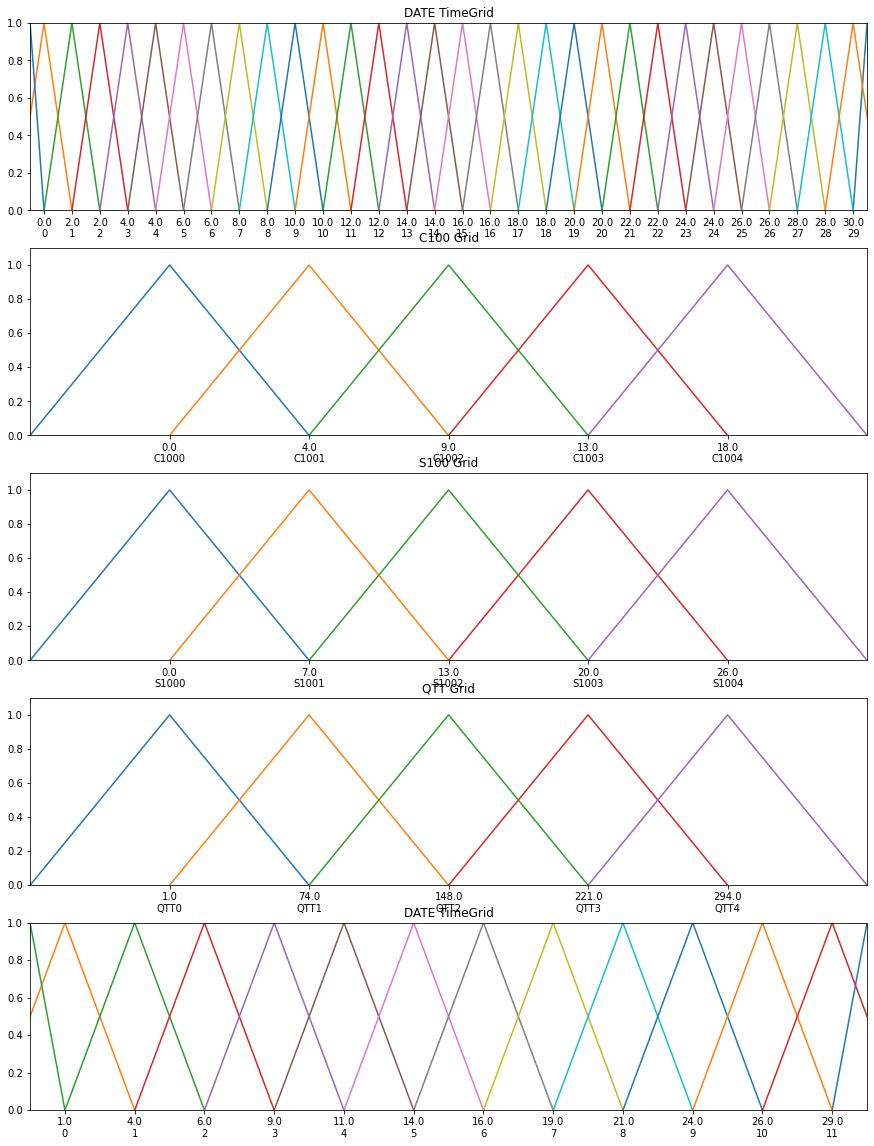

In [93]:
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime
from pyFTS.partitioners import Grid

fig, axes = plt.subplots(nrows=5, ncols=1,figsize=[15,20])

sp = {'seasonality': DateTime.day_of_year , 'names': ['Jan','Fev','Mar','Abr','Mai','Jun','Jul', 'Ago','Set','Out','Nov','Dez']}

month = variable.Variable("Month", data_label="DATE", partitioner=seasonal.TimeGridPartitioner, npart=12, 
                           data=multi_train, partitioner_specific=sp)
Date.partitioner.plot(axes[4])

sp = {'seasonality': DateTime.day_of_month , 'names': [str(k) for k in range(0,30)]}

Date = variable.Variable("DATE", data_label="DATE", partitioner=seasonal.TimeGridPartitioner, npart=30, data=multi_train, partitioner_specific=sp)
Date.partitioner.plot(axes[0])
# sp = {'seasonality': DateTime.minute_of_day, 'names': [str(k) for k in range(0,24)]}

c100 = variable.Variable("C100", data_label="C100", partitioner=Grid.GridPartitioner, npart=5, data=multi_train)
c100.partitioner.plot(axes[1])

s100 = variable.Variable("S100", data_label="S100", partitioner=Grid.GridPartitioner, npart=5, alpha_cut=.0, data=multi_train) 
s100.partitioner.plot(axes[2])

QTT = variable.Variable("QTT", data_label="QTT", partitioner=Grid.GridPartitioner, npart=5, data=multi_train) 
QTT.partitioner.plot(axes[3])

Look at the parameters of the S100, alpha here refers to the fuzzification procedure. 

In the α-cut fuzzification method, unlike the holistic method, only the membership degrees above the defined
α value are acceptable. Mathematically speaking for each Ai ∈ A˜, f(t) = Ai
, if µAi
(y(t)) ≥ α. Therefore it makes a good
balance between over-fitting and under-fitting.

## See Transform variables 

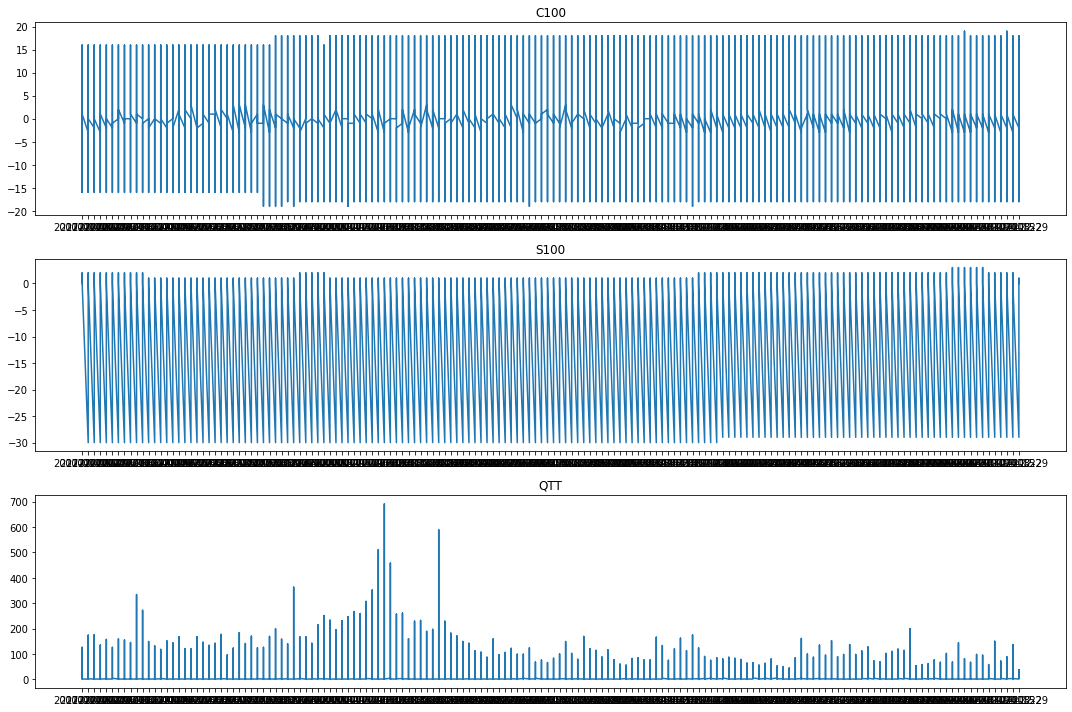

In [45]:
from pyFTS.common import Transformations
diff = Transformations.Differential(1)

fig, ax = plt.subplots(nrows=3, ncols=1,figsize=[15,10])

x = multi_train["DATE"].values

ax[0].set_title("C100")
ax[0].plot(x, diff.apply(multi_train["C100"].values))

ax[1].set_title("S100")
ax[1].plot(x, diff.apply(multi_train["S100"].values))

ax[2].set_title("QTT")
ax[2].plot(x, multi_train["QTT"].values)

plt.tight_layout()
plt.show()

In our case we are not going to transform them.

# Model training

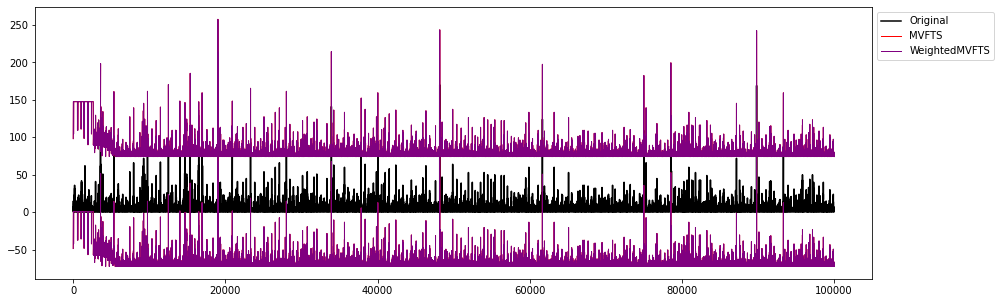

In [94]:
from pyFTS.models.multivariate import mvfts, wmvfts
from pyFTS.common import Util
from pyFTS.benchmarks import Measures

rows = []
colors = ['red', 'purple', 'green']

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(uni_test, label='Original',color='black')

for ct, method in enumerate([mvfts.MVFTS, wmvfts.WeightedMVFTS]):
    model = method(explanatory_variables=[month, Date, c100, s100, QTT], target_variable=QTT)
    model.fit(multi_train)
    forecasts = model.predict(multi_test, type='interval', alpha=0.05)

    Util.plot_interval(ax, forecasts, model.order, model.shortname, colors[ct])
  
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

## Other model 
Ensemble methods
- Silva, P. C. L et al. Probabilistic Forecasting with Seasonal Ensemble Fuzzy Time-Series XIII Brazilian Congress on Computational Intelligence, 2017. Rio de Janeiro, Brazil.
